### Customer Churn Model

Logistic regression used to model fictional telco company's customer churn based on a variety of possible factors. The churn column indicates whether or not the customer left within the last month. Other columns include gender, dependents, monthly charges, and many with information about the types of services each customer has. 

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

import pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
FILE_NAME = 'Telco-Customer-Churn.csv'
pd.options.display.max_columns = 10

data = pd.read_csv(FILE_NAME)
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,...,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,...,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,...,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,...,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,...,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,...,Yes,Electronic check,70.70,151.65,Yes


In [3]:
data.shape

(7043, 21)

Customers with 0 months tenure, have yet to accumulate TotalCharges. In this context they should not be part of training a model to predict churn so they will be omitted from the dataset

In [4]:
# Remove 0 tenure customers
df = data[data['tenure'] > 0].reset_index(drop=True)
df.shape

(7032, 21)

### DATA CLEANING

Most of the colomns can be transformed from Yes/No to 1/0. Other columns such as `StreamingMovies` have **No** and **No internet service** for the negative case and **Yes** for the positive case – we can still transform these types to 1/0

In [5]:
# CLEAN DATA USING THE FOLLOWING LAMBDA FUNCTIONS
inferred_yes_no_lambda = lambda x: 1 if x == 'Yes' else 0 if x == 'No' else 0 if 'No ' in x else None

column_lambda_funcs = {
    'customerID': lambda x: x, 
    'SeniorCitizen': lambda x: x,
    'tenure': lambda x: int(x),
    'MonthlyCharges': lambda x: float(x),
    'TotalCharges': lambda x: float(x),

    'Churn': inferred_yes_no_lambda,
    'Dependents': inferred_yes_no_lambda,
    'DeviceProtection': inferred_yes_no_lambda,
    'MultipleLines': inferred_yes_no_lambda,
    'OnlineSecurity': inferred_yes_no_lambda,
    'OnlineBackup': inferred_yes_no_lambda,
    'PaperlessBilling': inferred_yes_no_lambda,
    'Partner': inferred_yes_no_lambda,
    'PhoneService': inferred_yes_no_lambda,
    'StreamingTV': inferred_yes_no_lambda,
    'StreamingMovies': inferred_yes_no_lambda,
    'TechSupport': inferred_yes_no_lambda,
    
    'Contract': \
        lambda x: {'One year': 1, 'Two year': 1, 'Month-to-month': 0}.get(x),    
    'gender': \
        lambda x: {'Female': 1, 'Male': 0}.get(x),
    'InternetService': \
        lambda x: {'DSL': 1, 'Fiber optic': 1, 'No': 0}.get(x),    
    'PaymentMethod': \
        lambda x: {'Bank transfer (automatic)': 1, 
                   'Credit card (automatic)': 1, 
                   'Electronic check': 0,
                   'Mailed check': 0,}.get(x), 
}

for col in df.columns:
    if col not in ['customerID', 'SeniorCitizen']:
        df[col] = df[col].apply(column_lambda_funcs[col])

# RENAME columns
df.rename(
    columns={'gender':'Female', 
             'tenure':'Tenure', 
             'customerID': 'CustomerID',
             'PaymentMethod': 'AutoPayment'}, 
    inplace=True
)

### SPLIT DATA

In [6]:
# Predictors - Target split
X = df.drop(['CustomerID', 'Churn'], axis=1)
y = df['Churn']

# SPLIT DATA
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.20, random_state=8)

In [7]:
# Pipeline
model = Pipeline(
    steps=[
        ('standardize', StandardScaler()),
        ('logreg', LogisticRegression(penalty='l2', C=0.043, solver='liblinear')),
    ]
)

# Fit
model.fit(X_train, Y_train)

# Predict
y_hat = model.predict(X_test)

# Classification Report
print(classification_report(y_true=Y_test, y_pred=y_hat))

              precision    recall  f1-score   support

           0       0.86      0.89      0.87      1054
           1       0.63      0.56      0.59       353

    accuracy                           0.81      1407
   macro avg       0.74      0.72      0.73      1407
weighted avg       0.80      0.81      0.80      1407



In [8]:
# Dump Model
pickle.dump(model, open('model.pkl', 'wb'))

### Logistic Regression: Interpretation of Feature Weights

Define the odds of Y = 1 as,
$$odds = \frac{P(Y = 1)}{1 - P(Y = 1)} = e^{\beta_0 + \beta_1 X_1 + \cdots + \beta_p X_p}$$

Interpret the $\beta's$ in multiplicative terms with respect to the odds.

E.g., the interpretation of $\beta_1$ is, holding all the other variables/features fixed, for every increase of 1 in $X_1$, the odds of $Y = 1$ increases by a factor of $e^{\beta_1}$.

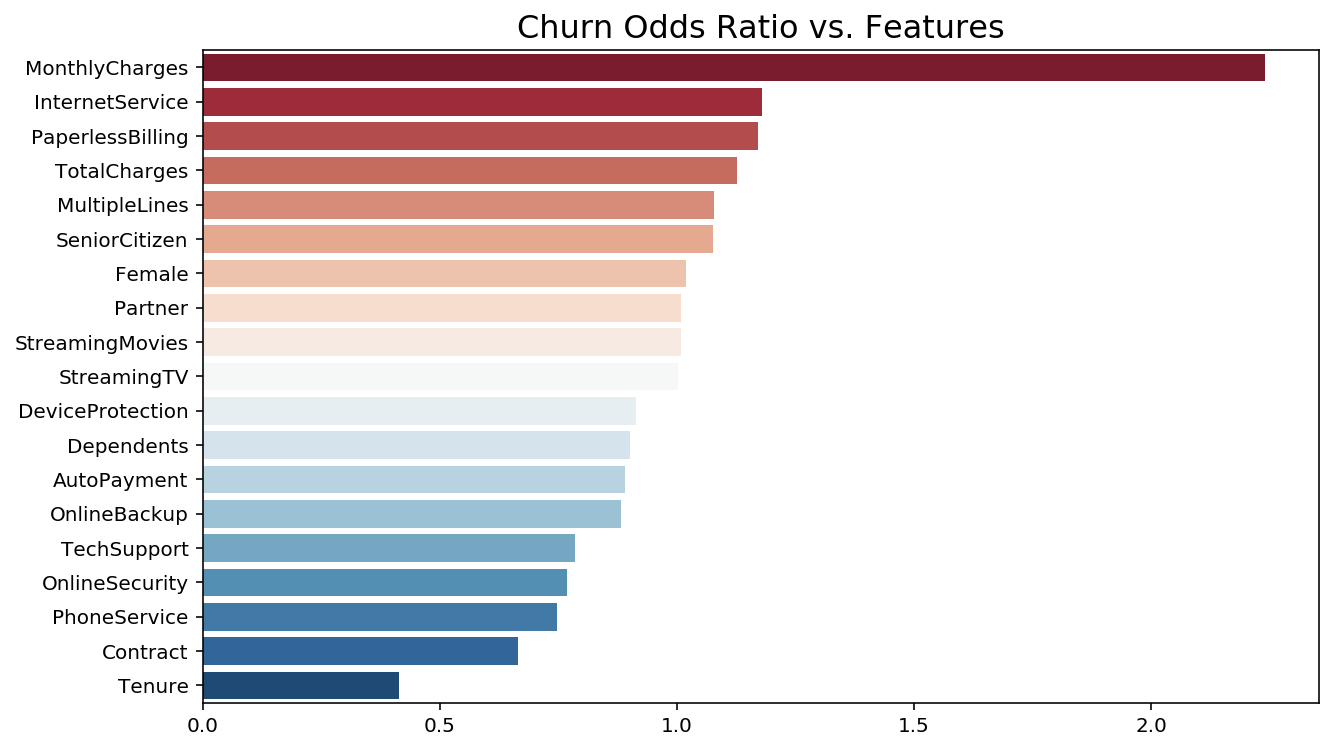

In [9]:
# Feature Weights
lr_coefs = model.named_steps['logreg'].coef_[0]
feature_weights = np.exp(lr_coefs)

# Sorted Feature Weights
sorted_features = feature_weights[np.argsort(feature_weights)]

plt.figure(figsize = (10,6))
plt.title('Churn Odds Ratio vs. Features', fontsize=16)
sns.barplot(sorted_features[::-1], X_train.columns[np.argsort(feature_weights)][::-1], palette="RdBu");